# OASIS Regression Challenge

Benvenuti! In questo notebook troverete le istruzioni per svolgere il test di **regressione multimodale** basato sul dataset OASIS.

## Struttura del Dataset
- Avete a disposizione un file Excel/CSV (`oasis_cross-sectional.xlsx`) con le **informazioni cliniche/demografiche**. Ciascuna riga fa riferimento a un soggetto, identificato da un ID (ad esempio `OAS1_0004_MR1`). 
- Le **immagini MRI** sono organizzate in cartelle che indicano lo stato di demenza, ad esempio `NonDemented/`, `MildDemented/`, ecc. In ciascuna cartella, i file immagine presentano un prefisso corrispondente all'ID del soggetto (ad esempio `OAS1_0004_MR1_1.jpg`, `OAS1_0004_MR1_2.jpg`, ecc.).

## Obiettivo
Dovete realizzare un **modello di regressione** che predica un indicatore (a scelta, ad esempio **età** o **punteggio cognitivo** come MMSE) combinando:
1. Le **feature tabellari** (età, sesso, CDR, eTIV, nWBV, ecc.).
2. Le **feature estratte** dalle immagini MRI.

## Suggerimenti
- Potete usare una **CNN pre-addestrata** (o una rete a vostra scelta) per estrarre un vettore di feature dalle immagini. 
- Potete fare **early fusion** concatenando feature tabellari e visive, oppure **late fusion** combinando le predizioni di due modelli.
- Usate metriche come **MAE**, **MSE** o **R²** per valutare il vostro modello.

## Consegna
- Completate le celle sottostanti con il vostro codice.
- Fornite un breve commento ai risultati, spiegando eventuali scelte di preprocessing e di modellazione.

Buon lavoro!

## 1. Setup e Import delle Librerie
Inserite qui le importazioni di base (numpy, pandas, matplotlib, ecc.) e qualsiasi altra libreria che ritenete utile.


First, let's create a virtual environment: open the terminal at the project folder and run:

 - python -m venv venv (to create it)

 - source venv/bin/activate (to activate it)

 - pip install [dependencies]

 - pip freeze > requirements.txt (for reproducibility)

In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## 2. Caricamento dei Dati Tabellari
Leggete il file `oasis_cross-sectional.xlsx` (o CSV), esplorate le colonne (età, sesso, CDR, eTIV, nWBV, ASF, Delay, ecc.) e verificate la presenza di valori mancanti.

### Task
- Caricare il file in un DataFrame.
- Fare una prima **analisi esplorativa** (distribuzioni, statistiche descrittive, correlazioni) per capire i dati.


In [638]:
df = pd.read_excel('dataset/oasis_cross-sectional.xlsx')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


In [639]:
# null data percentage?
(df.isnull().sum() / len(df)) * 100

ID        0.000000
M/F       0.000000
Hand      0.000000
Age       0.000000
Educ     46.100917
SES      50.458716
MMSE     46.100917
CDR      46.100917
eTIV      0.000000
nWBV      0.000000
ASF       0.000000
Delay    95.412844
dtype: float64

The field Delay is composed by null values for 95% of its entirety. From the documentation: "Additionally, for 20 of the nondemented subjects, images from a subsequent scan
session after a short delay (less than 90 days) are also included as a means of assessing acquisition
reliability."

Fields like Educ, SES, MMSE and CDR present a lot of null values (50% approximately for all of them). I need further investigation for them

In [640]:
df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


In [641]:
print(df['M/F'].value_counts())
f_percentage = len(df[df["M/F"] == "F"]) / len(df) * 100
print(f'{f_percentage:.2f}% of the dataset is Female')

M/F
F    268
M    168
Name: count, dtype: int64
61.47% of the dataset is Female


In [642]:
print(df['Hand'].value_counts())

Hand
R    436
Name: count, dtype: int64


Hand is a constant (R) for all the elements. That means it doesn't add any "information" to our case.

Let's plot other fields to visualize them

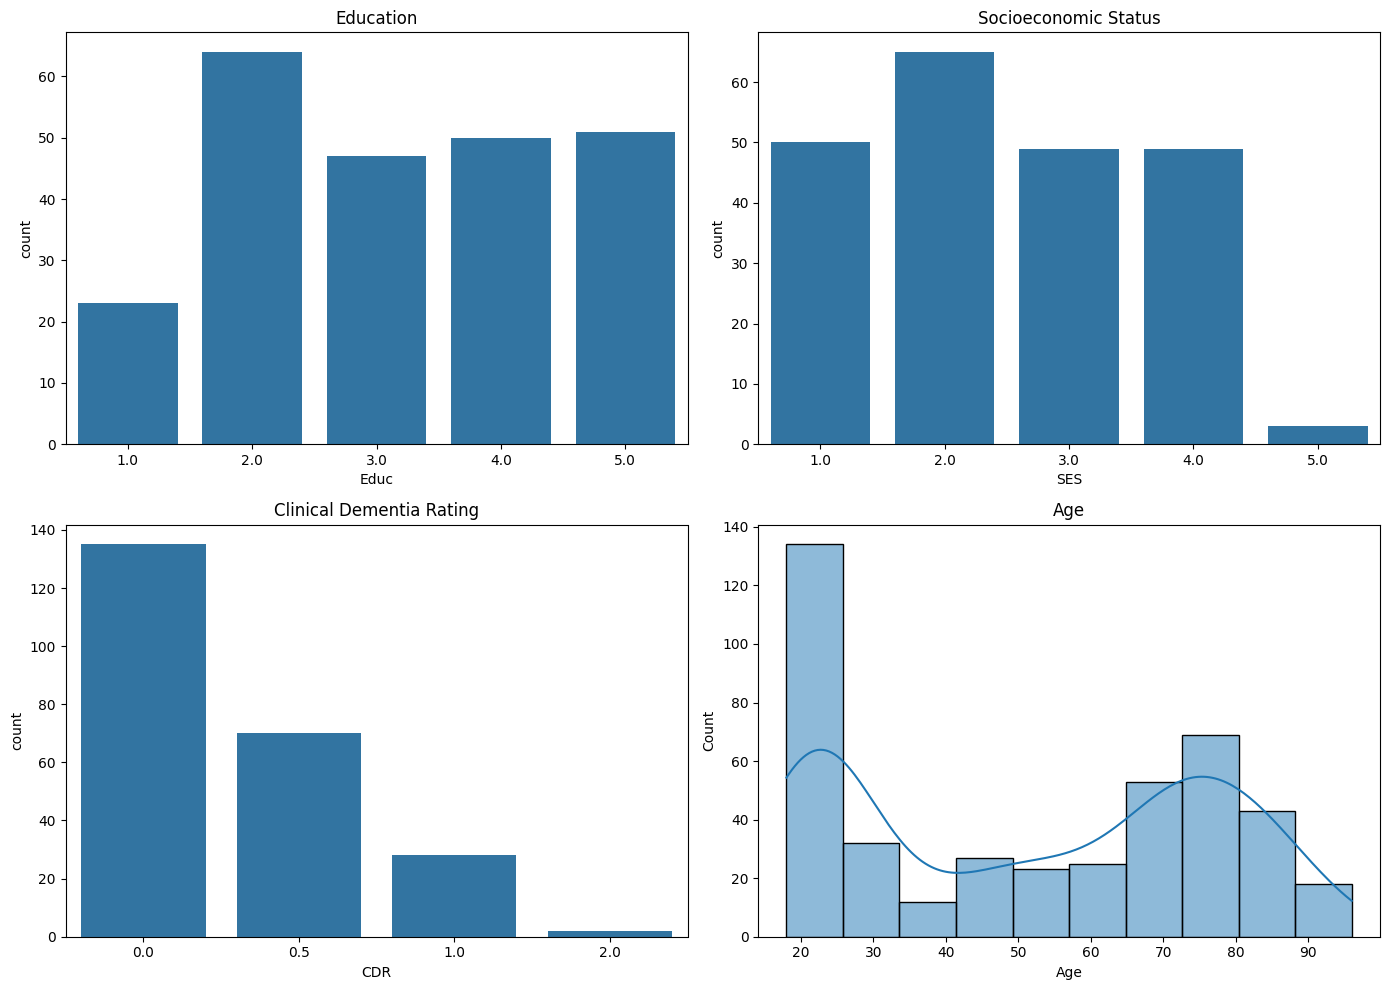

In [643]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(x='Educ', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Education')

sns.countplot(x='SES', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Socioeconomic Status')

sns.countplot(x='CDR', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Clinical Dementia Rating')

sns.histplot(df['Age'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Age')

plt.tight_layout()

plt.show()


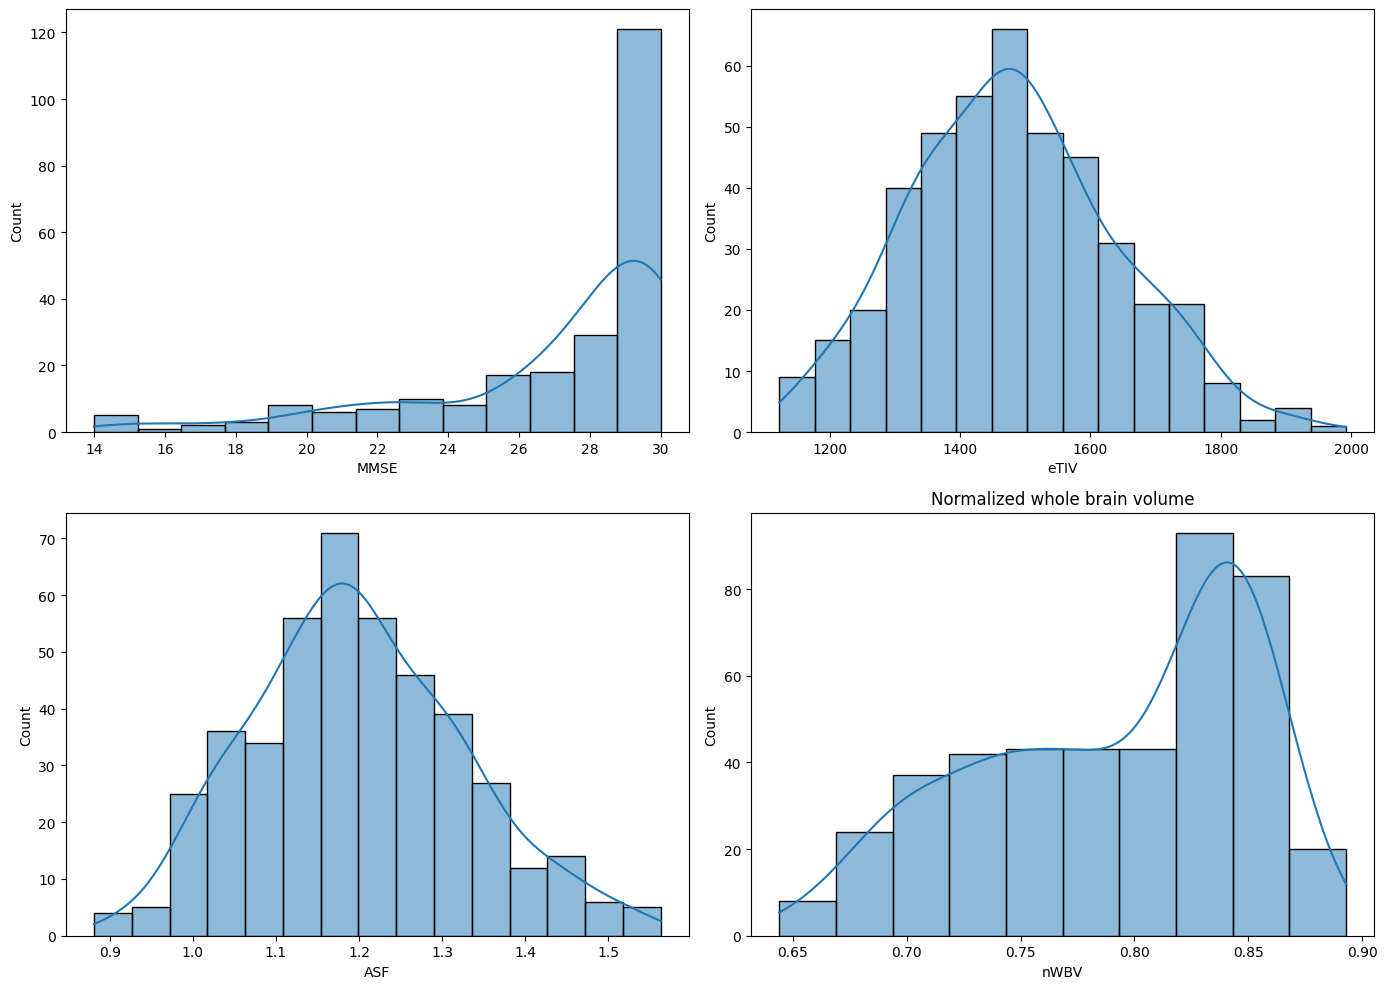

In [644]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df['MMSE'], kde=True, ax=axes[0, 0])
axes[1, 1].set_title('Mini-Mental State Exam (MMSE)')

sns.histplot(df['eTIV'], kde=True, ax=axes[0, 1])
axes[1, 1].set_title('Estimated total intracranial volume')

sns.histplot(df['ASF'], kde=True, ax=axes[1, 0])
axes[1, 1].set_title('Atlas scaling factor')

sns.histplot(df['nWBV'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Normalized whole brain volume')

plt.tight_layout()

plt.show()


Let's find some correlation among numeric fields

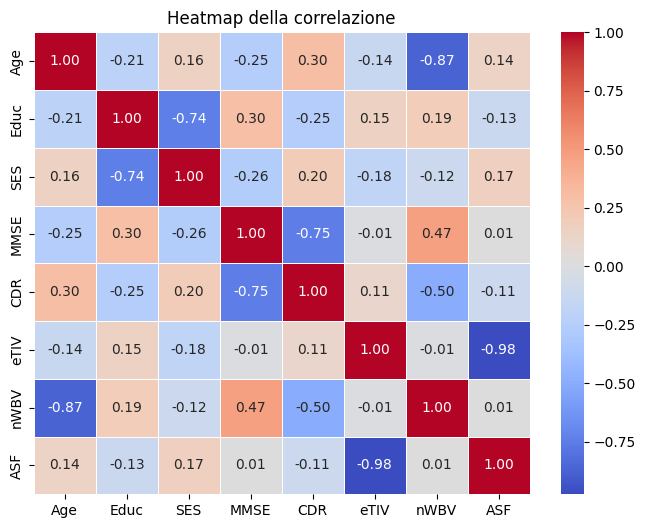

In [645]:
corr = df[[
'Age',
'Educ',
'SES',
'MMSE',
'CDR',
'eTIV',
'nWBV', 
'ASF']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap della correlazione')
plt.show()



Observing correlation matrix, I notice that:
 - nWBV and Age are anticorrelated
 - ASF and eTIV are anticorrelated
 - SES and Educ are anticorrelated (why? the more you are educated the higher your SES, no?)
 - CDR and MMSE are anticorrelated (as expected)

anti/correlation can help me to identify features that can be "unified" in order to reduce dimensionality. For the moment I only keep this information without further actions.

## 3. Preprocessing dei Dati Tabellari
Qui potete:
- Gestire eventuali valori mancanti.
- Codificare variabili categoriche (ad es. `M`/`F`) in numeriche.
- Normalizzare o standardizzare le feature, se necessario.
- Selezionare le colonne che userete come input tabellari.


### Column deletion
During analysis step, I noticed we have useless columns that I can drop

The field Delay is composed by null values for 95% of its entirety. From the documentation: "Additionally, for 20 of the nondemented subjects, images from a subsequent scan
session after a short delay (less than 90 days) are also included as a means of assessing acquisition
reliability."

I believe this feature is negligible and its 95% missing data makes it useless, so I can discard it.

In [646]:
df = df.drop('Delay', axis=1)

Hand is a constant (R) for all the elements. That means it doesn't add any "information" to our case. I can drop it.

In [647]:
df = df.drop('Hand', axis=1)

### Missing values

Fields like Educ, SES, MMSE and CDR present a lot of null values (50% approximately for all of them). I believe they can give me some "information" so I can't just drop them.
I decide to use the most naive approach for filling missing values, id est replacing them with the mean value. In this case, since these fields are all INT, I'm gonna replace them with the rounded mean.

Example:

Educ	3.1787 -> 3.0

In [648]:
df['Educ'].fillna(round(df['Educ'].mean()), inplace=True)
df['SES'].fillna(round(df['SES'].mean()), inplace=True)
df['MMSE'].fillna(round(df['MMSE'].mean()), inplace=True)
df['CDR'].fillna(round(df['CDR'].mean()), inplace=True)

/var/folders/cm/4652rkf53h3539_dz7dvc7b80000gn/T/ipykernel_33395/192365012.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Educ'].fillna(round(df['Educ'].mean()), inplace=True)
/var/folders/cm/4652rkf53h3539_dz7dvc7b80000gn/T/ipykernel_33395/192365012.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [649]:
df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,436.000000,436.000000,436.000000,436.000000,436.00000,436.000000,436.000000,436.000000
mean,51.357798,3.096330,2.243119,27.034404,0.15367,1481.919725,0.791670,1.198894
std,25.269862,0.966037,0.825219,2.711611,0.31515,158.740866,0.059937,0.128682
min,18.000000,1.000000,1.000000,14.000000,0.00000,1123.000000,0.644000,0.881000
25%,23.000000,3.000000,2.000000,27.000000,0.00000,1367.750000,0.742750,1.111750
50%,54.000000,3.000000,2.000000,27.000000,0.00000,1475.500000,0.809000,1.190000
75%,74.000000,3.000000,2.000000,29.000000,0.00000,1579.250000,0.842000,1.284250
max,96.000000,5.000000,5.000000,30.000000,2.00000,1992.000000,0.893000,1.563000


In [650]:
# null data percentage?
(df.isnull().sum() / len(df)) * 100

ID      0.0
M/F     0.0
Age     0.0
Educ    0.0
SES     0.0
MMSE    0.0
CDR     0.0
eTIV    0.0
nWBV    0.0
ASF     0.0
dtype: float64

Now I don't have any missing values

### Preprocessing

Let's adjust some things:
 - Convert categorical data into numerical data
 - Scale numerical features except Age, which gonna be the target for the regression

In [651]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Age     436 non-null    int64  
 3   Educ    436 non-null    float64
 4   SES     436 non-null    float64
 5   MMSE    436 non-null    float64
 6   CDR     436 non-null    float64
 7   eTIV    436 non-null    int64  
 8   nWBV    436 non-null    float64
 9   ASF     436 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 34.2+ KB


In [652]:
# Convert M/F into numeric
df['M/F'] = df['M/F'].map({'M': 0, 'F': 1})

# normalize other columns, except
# - ID: to extract features from images
# - Age: because it's gonna be my target
scaler = MinMaxScaler()

columns_to_scale = df.columns.drop(['ID', 'Age'])
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [653]:
df.describe()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,0.614679,51.357798,0.524083,0.310780,0.814650,0.076835,0.413026,0.593051,0.466121
std,0.487230,25.269862,0.241509,0.206305,0.169476,0.157575,0.182671,0.240711,0.188684
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.500000,0.250000,0.812500,0.000000,0.281646,0.396586,0.338343
50%,1.000000,54.000000,0.500000,0.250000,0.812500,0.000000,0.405639,0.662651,0.453079
75%,1.000000,74.000000,0.500000,0.250000,0.937500,0.000000,0.525029,0.795181,0.591276
max,1.000000,96.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now data is clean for further processing

## 4. Caricamento delle Immagini MRI e Estrazione di Feature
### Task
- Per ogni riga del DataFrame, individuare la cartella corrispondente allo stato (NonDemented, MildDemented, ecc.) e caricare le immagini che iniziano con l'ID (es. `OAS1_0004_MR1_1.jpg`, `OAS1_0004_MR1_2.jpg`, ecc.).
- Estrarre feature (ad esempio con una CNN pre-addestrata tipo ResNet, VGG, ecc.).
- Generare un **vettore di feature** che rappresenti l'intero soggetto. Se ci sono più immagini per lo stesso soggetto, potete:
  - fare una **media** dei vettori di feature, oppure
  - scegliere una sola immagine (se volete semplificare), oppure
  - concatenare e poi ridurre dimensionalmente.

In questa sezione potete decidere la strategia che ritenete più opportuna.

In [ ]:
# Inserite qui il vostro codice di estrazione feature...
# Potete usare keras, PyTorch o qualunque metodo preferiate.
# Ricordate di gestire i percorsi delle immagini in base alla cartella e all'ID del soggetto.

# transform images in PIL format, resize and normalize to make them ready for the model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # because ResNet is trained with images with this size
    transforms.ToTensor(),
    # normalizes the image using mean and standard deviation of the ImageNet dataset, which ResNet is trained on
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# let's use pretrained model ResNet 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()
print()


In [655]:
# function to extract normalized features from an image
def extract_features(img):
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(img).cpu().numpy().flatten()

    return features

# function to identify the right folder to look for images
def cdr_to_folder(cdr):
    cdr = float(cdr)
    match cdr:
        case 0.0:
            return 'Non Demented'
        case 0.25:
            return 'Very mild Dementia'
        case 0.5:
            return 'Mild Dementia'
        case 1.0:
            return 'Moderate Dementia'
        case _:
            raise ValueError('No folder for this CDR value!')

*GOOGLE COLAB EXECUTION: start*

In [656]:
ENV = 'local'
if (ENV == 'googlecolab'):
    features_list = []

    for idx, row in df.iterrows():
        try:

            subject_id = row['ID']
            subject_folder = os.path.join('/Users/maurorusso/Desktop/dataset', cdr_to_folder(row['CDR']))
            
            # images with same ID
            images = [f for f in os.listdir(subject_folder) if f.startswith(subject_id)]
            images = images[:3] # limit for performance
            subject_features = []

            for img_name in images:
                img_path = os.path.join(subject_folder, img_name)

                if os.path.exists(img_path):
                    
                    img = cv2.imread(img_path)

                    if img is not None:
                        features = extract_features(img)
                        subject_features.append(features)

            if subject_features:
                mean_features = np.mean(subject_features, axis=0)
                features_list.append(mean_features)
            else:
                features_list.append(np.zeros(1000))

        except Exception as e:
            print(f"Error processing subject {subject_id}: {e}")
            features_list.append(np.zeros(1000))

    features_df = pd.DataFrame(features_list)

*GOOGLE COLAB EXECUTION: end*

I executed the previous cell on Google Colab in order to take advantage of its GPU. Then I saved the results on images_features.xlsx.
That's why I'm going to use this file from now on

In [657]:
features_df = pd.read_excel('dataset/images_features.xlsx')

In [658]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 3.3 MB


In [659]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.699802,-0.650316,0.452265,2.855964,0.270075,5.121613,2.072589,-2.801046,-1.639527,-0.561964,...,4.405432,-1.518120,-2.239544,0.738229,1.133083,-0.038807,1.919313,1.865199,0.716884,0.954580
2,-1.064473,-1.189709,-1.811311,0.874628,-0.857145,5.003307,1.304967,-2.894527,-1.745063,0.200167,...,4.441310,-0.771034,-1.872802,2.769315,1.952033,0.357916,2.534865,1.308290,2.310597,1.065802
3,-0.148567,-1.822511,-0.984584,2.036021,0.283534,2.757607,-0.798520,-3.889442,-2.480008,0.342111,...,3.253373,-1.510509,-1.823562,-0.003692,0.429872,-0.569851,1.157021,1.055218,0.445982,2.220859
4,-0.868474,-1.171440,-1.152975,2.820372,0.752698,4.585848,1.253073,-4.610528,-2.017856,-0.527045,...,5.191686,-1.741859,-1.439596,-0.961976,-1.666507,-0.483877,0.756650,1.795162,1.600486,0.806422


In [660]:
features_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,...,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,-0.589856,-0.889784,-0.676272,1.536820,-0.187103,2.878652,0.319891,-2.337241,-1.146899,0.063942,...,3.453119,-1.291185,-1.780190,-0.019421,0.066205,0.075657,0.631877,0.643281,0.865829,1.151070
std,0.726154,0.719311,0.761706,0.938490,0.550000,1.528836,0.757682,1.408491,0.884489,0.816772,...,1.841132,0.836481,0.982626,1.283338,1.476505,0.696823,1.102923,1.019607,0.683274,0.846360
min,-2.784264,-2.865099,-2.659982,-0.109702,-2.115638,0.000000,-1.519583,-4.816790,-3.314149,-2.486289,...,0.000000,-3.213697,-4.252085,-3.136457,-4.099911,-2.187121,-2.667454,-1.899683,-1.233273,-0.282326
25%,-1.080292,-1.426754,-1.229813,0.934844,-0.500178,2.368845,-0.057509,-3.389622,-1.785199,-0.384256,...,2.761074,-1.906646,-2.466363,-0.924571,-0.834469,-0.284329,0.000000,0.000000,0.290544,0.563558
50%,-0.540967,-0.975819,-0.665577,1.676919,-0.108191,3.195179,0.132901,-2.724489,-1.296405,0.000000,...,3.772568,-1.403760,-1.967132,0.000000,0.000000,0.000000,0.471068,0.486413,0.944155,1.138749
75%,0.000000,-0.207660,0.000000,2.172145,0.073562,3.892858,0.759767,-1.611430,-0.448774,0.479999,...,4.641987,-0.715359,-1.371675,0.691384,1.049717,0.420142,1.357256,1.230301,1.378693,1.628086
max,1.455964,1.798208,1.669834,3.869064,2.952830,7.543048,3.004899,1.260718,2.447325,3.080548,...,8.186080,0.600166,0.000000,3.910033,4.938690,3.037015,3.994556,4.765202,2.553223,5.120196


### Reduce dimensionality

1000 features is a lot. Let's reduce the dimensionality with PCA. I will try different values of variance and then decide what is the best trade-off

In [661]:
pca99 = PCA(n_components=0.99)  # 99% of variance
pca97 = PCA(n_components=0.97)  # 97% of variance
pca95 = PCA(n_components=0.95)  # 95% of variance

reduced_features99 = pca99.fit_transform(features_df)
reduced_features97 = pca97.fit_transform(features_df)
reduced_features95 = pca95.fit_transform(features_df)

print(f"Original feature size: {features_df.shape[1]}")
print(f"Reduced feature size (variance = 99%): {reduced_features99.shape[1]}")
print(f"Reduced feature size (variance = 97%): {reduced_features97.shape[1]}")
print(f"Reduced feature size (variance = 95%): {reduced_features95.shape[1]}")

Original feature size: 1000
Reduced feature size (variance = 99%): 87
Reduced feature size (variance = 97%): 49
Reduced feature size (variance = 95%): 34


I think that the result for variance = 97% is a good trade-off between reducing dimensionality and not loosing too much information, so let's go on with this

In [662]:
reduced_features = pd.DataFrame(reduced_features97)

In [663]:
# normalize
scaler = MinMaxScaler()

reduced_features = pd.DataFrame(scaler.fit_transform(reduced_features))

In [664]:
reduced_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,...,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,0.686010,0.551763,0.390510,0.556117,0.522150,0.463909,0.507877,0.519014,0.560134,0.547923,...,0.475146,0.603615,0.468824,0.518146,0.343624,0.589404,0.561708,0.526186,0.513022,0.560729
std,0.310568,0.201661,0.144141,0.136161,0.155473,0.144949,0.132818,0.140503,0.146549,0.128488,...,0.109578,0.136764,0.150587,0.168931,0.117496,0.120360,0.153277,0.137478,0.152602,0.116451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.723350,0.412538,0.309550,0.485869,0.432678,0.380463,0.449562,0.452345,0.478661,0.475058,...,0.410407,0.537255,0.386937,0.427504,0.275948,0.522476,0.487421,0.459669,0.420858,0.494015
50%,0.807881,0.537801,0.390877,0.586712,0.544663,0.481637,0.492531,0.500532,0.566241,0.561076,...,0.471918,0.609660,0.470647,0.523938,0.337972,0.581190,0.562872,0.524099,0.515715,0.561818
75%,0.859200,0.700170,0.452723,0.623127,0.604788,0.530504,0.585108,0.597448,0.639995,0.610703,...,0.540598,0.675735,0.545729,0.616292,0.403318,0.657148,0.649797,0.597854,0.593612,0.625532
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 5. Fusione delle Feature e Preparazione del Dataset per la Regressione
Adesso dovete **unire** (o "fondere") le feature tabellari con quelle estratte dalle immagini.
### Task
- Creare un vettore di input multimodale (feature tabellari + feature immagini) per ogni soggetto.
- Scegliere la **variabile target** (ad es. l'età o il punteggio MMSE) che volete predire.
- Preparare i vostri `X` (matrice di input) e `y` (vettore target) da passare al modello.


In [665]:
# Inserite qui il vostro codice per unire le feature e creare X, y...

# We don't need ID field anymore
df = df.drop('ID', axis=1)

# Concatenate data and images features
full_df = pd.concat([df, reduced_features], axis=1)

# Convert columns names as string to avoid type errors while using models
full_df.columns = full_df.columns.astype(str)

X = full_df
y = X.pop('Age')

X

,M/F,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,0,1,...,39,40,41,42,43,44,45,46,47,48
0,1.0,0.25,0.50,0.9375,0.00,0.254315,0.397590,0.623167,2.664535e-15,0.537801,...,0.471918,0.609660,0.470647,0.523938,0.337972,0.581190,0.562872,0.524099,0.515715,0.561818
1,1.0,0.75,0.00,0.9375,0.00,0.027618,0.666667,0.953079,8.921603e-01,0.400111,...,0.274708,0.619604,0.373845,0.510707,0.193481,0.688582,0.660806,0.279237,0.578288,0.562524
2,1.0,0.75,0.50,0.8125,0.25,0.380898,0.257028,0.478006,8.600261e-01,0.320438,...,0.228894,0.420524,0.395390,0.688261,0.456498,0.546404,0.564971,0.497512,0.695907,0.691241
3,0.0,0.50,0.25,0.8125,0.00,0.535098,0.638554,0.328446,8.506816e-01,0.562156,...,0.691602,0.702084,0.652418,0.936193,0.298301,0.539154,0.629765,0.470547,0.459226,0.582942
4,0.0,0.50,0.25,0.8125,0.00,0.706559,0.819277,0.189150,9.058704e-01,0.776692,...,0.394103,0.370673,0.470821,0.617885,0.302830,0.509309,0.423387,0.351009,0.265598,0.810137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.0,0.50,0.25,0.8125,0.00,0.398159,0.815261,0.460411,8.906298e-01,0.881461,...,0.526196,0.545327,0.597410,0.521353,0.290549,0.605115,0.564979,0.608371,0.644300,0.679924
432,0.0,0.50,0.25,0.8125,0.00,0.645570,0.586345,0.236070,7.358974e-01,0.273002,...,0.563752,0.870621,0.150183,0.597636,0.376782,0.929743,0.628391,0.635019,0.530548,0.611359
433,0.0,0.50,0.25,0.8125,0.00,0.525892,0.851406,0.337243,8.502809e-01,0.423548,...,0.693585,0.664028,0.279251,0.699364,0.501314,0.591435,0.724955,0.525312,0.674688,0.432731
434,1.0,0.50,0.25,0.8125,0.00,0.159954,0.871486,0.746334,8.047897e-01,0.743228,...,0.466679,0.688228,0.500515,0.493291,0.313160,0.709906,0.637742,0.587641,0.776105,0.532621


In [666]:
y

0      74
1      55
2      73
3      28
4      18
       ..
431    20
432    22
433    22
434    20
435    26
Name: Age, Length: 436, dtype: int64

## 6. Definizione e Addestramento del Modello di Regressione
### Task
- Selezionare un modello di regressione (ad es. Linear Regression, Random Forest, XGBoost, o una rete neurale) e addestrarlo sui dati.
- Suddividere i dati in training/validation (o usare cross-validation) e valutare le metriche di regressione (RMSE, MAE, R², ecc.).


In [667]:
# Inserite qui il vostro codice di modellazione e training...
# Esempio con scikit-learn:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# Calcolo metriche...

In [668]:
# training - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# let's try different models
lr_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor()

In [669]:
# training
lr_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
print()

### Neural Network

Let's build a custom Neural Network to see if I can do better than the others model. 

The input dataset is relatively small, we can build a "compact" neural network

*NOTE*: differents architectures and parameters have been tested. I report only the best model found so far to not make this notebook huge.

In [ ]:
# model architecture
nn = Sequential([
    Dense(128, activation='relu', input_shape=(57,)),
    BatchNormalization(), # normalize the inputs of each layer
    Dropout(0.3),  # dropout to reduce overfitting
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1)  # output layer for regression
])

# compile the model
nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [671]:
# training
history = nn.fit(
    X_train, y_train,
    epochs=500, # I can exaggerate, there is early stopping
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)


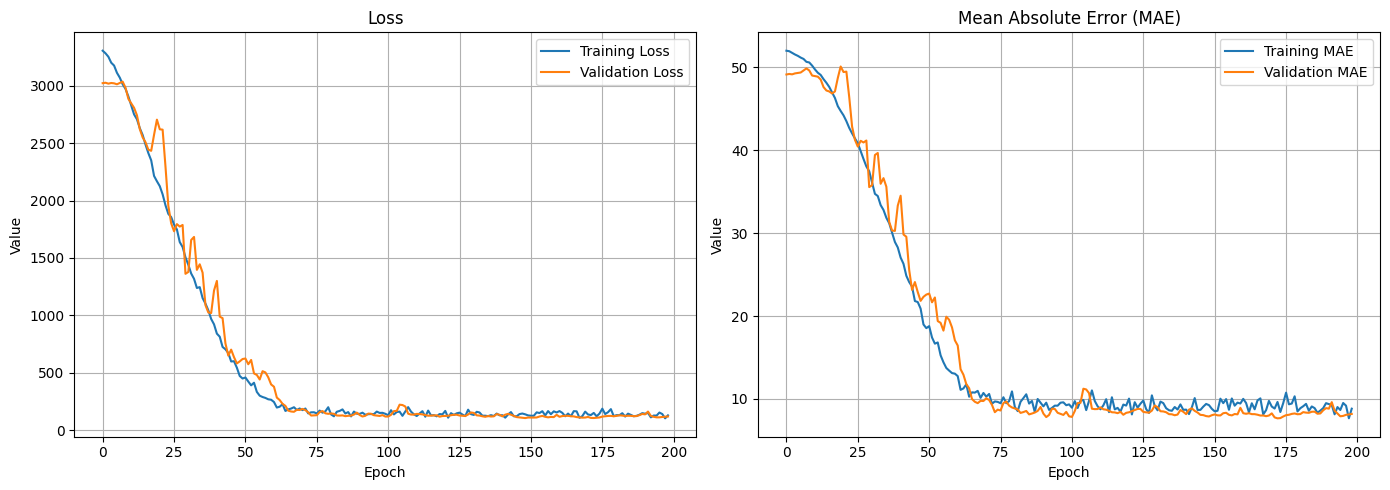

In [672]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid()

# Plot MAE
if 'mae' in history.history:
    axs[1].plot(history.history['mae'], label='Training MAE')
if 'val_mae' in history.history:
    axs[1].plot(history.history['val_mae'], label='Validation MAE')
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

The early stopping made the model stop its training after 190 epochs (approximately)

## 7. Valutazione del Modello e Conclusioni
### Task
- Calcolare le metriche di valutazione (MAE, RMSE, R², ecc.).
- Confrontare i risultati con eventuali baseline (es. modello che usa solo dati tabellari, modello che usa solo immagini, ecc.).
- Scrivere le vostre osservazioni finali: quali difficoltà avete incontrato, possibili miglioramenti futuri, ecc.

In [673]:
# Inserite qui il vostro codice di valutazione e un commento finale sui risultati.
# Esempio:
# from sklearn.metrics import mean_squared_error, r2_score
# mse = mean_squared_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)
# print("MSE:", mse)
# print("R^2:", r2)

### Metrics

I gonna use MAE and R² as metrics. 

MAE is perfect for this case: a MAE = N means that the model's predicted age is off by about N years. So we can expect a MAE < 5 as a good result and a MAE > 10 as a bad result. 

R² measures how well the model explains the variance in the target variable, so we can consider it as a generic evaluation of the model. It ranges in [0, 1] and the higher the better

In [674]:
def single_model_metrics(model):
    y_pred = model.predict(X_test)
    return [mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [675]:
def calc_metrics(models_labels, metrics_models):
    metrics = [single_model_metrics(model) for model in metrics_models]
    maes = [x[0] for x in metrics]
    r2s = [x[1] for x in metrics]

    return pd.DataFrame({
        'Models': models_labels,
        'MAE': maes,
        'R²': r2s
    })

In [676]:
metrics = calc_metrics(
    ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'Neural Network'], 
    [lr_model, random_forest_model, xgb_model, nn])
print(metrics)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                  Models       MAE        R²
0       LinearRegression  7.711187  0.853135
1  RandomForestRegressor  6.013864  0.911021
2           XGBRegressor  6.706549  0.887733
3         Neural Network  6.365244  0.895064


RandomForest and Neural Network are the best models, the others are good too

### Same models different data

Let's try the same models with different data, id est one case where data is only the file oasis_cross-sectional.xlsx and a second case where data is only the file images_features.xlsx. We are not going to use the Neural Network because its architecture makes sense only for that case.

#### Only oasis_cross-sectional.xlsx

In [677]:
# let's use the dataframe already preprocessed
df_1 = df.copy()

X = df_1
y = X.pop('Age')

X

,M/F,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1.0,0.25,0.50,0.9375,0.00,0.254315,0.397590,0.623167
1,1.0,0.75,0.00,0.9375,0.00,0.027618,0.666667,0.953079
2,1.0,0.75,0.50,0.8125,0.25,0.380898,0.257028,0.478006
3,0.0,0.50,0.25,0.8125,0.00,0.535098,0.638554,0.328446
4,0.0,0.50,0.25,0.8125,0.00,0.706559,0.819277,0.189150
...,...,...,...,...,...,...,...,...
431,0.0,0.50,0.25,0.8125,0.00,0.398159,0.815261,0.460411
432,0.0,0.50,0.25,0.8125,0.00,0.645570,0.586345,0.236070
433,0.0,0.50,0.25,0.8125,0.00,0.525892,0.851406,0.337243
434,1.0,0.50,0.25,0.8125,0.00,0.159954,0.871486,0.746334


In [678]:
# training - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# let's try different models
lr_model_1 = LinearRegression()
random_forest_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_1 = XGBRegressor()

In [679]:
# training
lr_model_1.fit(X_train, y_train)
random_forest_model_1.fit(X_train, y_train)
xgb_model_1.fit(X_train, y_train)
print()

In [680]:
metrics1 = calc_metrics(
    ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor'], 
    [lr_model_1, random_forest_model_1, xgb_model_1])
print(metrics1)

                  Models       MAE        R²
0       LinearRegression  7.852681  0.857096
1  RandomForestRegressor  5.917614  0.906643
2           XGBRegressor  6.454067  0.894826


RandomForestRegressor performances improved! (and XGBRegressor too by a little)

#### Only images_features.xlsx

In [681]:
# let's use images features already preprocessed
df_2 = reduced_features.copy()

# Convert columns names as string to avoid type errors while using models
df_2.columns = df_2.columns.astype(str)

X = df_2
y = y # we already have the target

In [682]:
# training - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# let's try different models
lr_model_2 = LinearRegression()
random_forest_model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_2 = XGBRegressor()

In [683]:
# training
lr_model_2.fit(X_train, y_train)
random_forest_model_2.fit(X_train, y_train)
xgb_model_2.fit(X_train, y_train)
print()

In [684]:
metrics2 = calc_metrics(
    ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor'], 
    [lr_model_2, random_forest_model_2, xgb_model_2])
print(metrics2)

                  Models        MAE        R²
0       LinearRegression  14.714471  0.552389
1  RandomForestRegressor  18.487328  0.351263
2           XGBRegressor  18.581306  0.305293


Only images features gave me way worse results

### Conclusion

In [685]:
pd.DataFrame({
    'Cases': ['Combination', 'Only Data', 'Only Images'],
    'LR MAE': [metrics['MAE'][0], metrics1['MAE'][0], metrics2['MAE'][0]],
    'RF MAE': [metrics['MAE'][1], metrics1['MAE'][1], metrics2['MAE'][1]],
    'XGB MAE': [metrics['MAE'][2], metrics1['MAE'][2], metrics2['MAE'][2]]

})

,Cases,LR MAE,RF MAE,XGB MAE
0,Combination,7.711187,6.013864,6.706549
1,Only Data,7.852681,5.917614,6.454067
2,Only Images,14.714471,18.487328,18.581306


We obtained the best MAE in the Only Data case (except for LinearRegression), this means that the tabular data is highly informative regarding the Age. We can not say the same for the images: the Only Images is the worst case (and by a lot). This means those images are not strongly correlated with age, maybe they are more suited for dementia classification.

Eventually, we can say that age might be better predicted using structured clinical data rather than MRI-derived features.

*Future improvements*: In this experiment, I limited the number of images per subject to 3 in order to maintain an acceptable running time. This, obviously, reduced the amount of information extracted from the MRI images. A possible improvement would be to use all available images per subject, but this would require more computational power to handle the higher volume of data and more complex feature extraction.